In [ ]:
# 데이터 로드
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 로드
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# 정규화 패키지
from sklearn.preprocessing import MinMaxScaler

In [ ]:
### 함수 정의 구간
# 데이터 업로드 _utf
def upload_data_utf(file_name):
  rtn = pd.read_csv(file_name, encoding = 'utf-8')
  rtn = pd.DataFrame(rtn)

  return rtn

def upload_data_cp(file_name):
  rtn = pd.read_csv(file_name, encoding = 'cp949', delimiter = '\t')
  rtn = pd.DataFrame(rtn)

  return rtn

### 데이터 정규화
  # Min-Max Scaling
  # 0에서 1사이로 정규화
def scaling(data, loctaion):
  # 스케일 대상 column
  scaleColumn = ['건축년도', '전용면적'] + location
  rtn = data

  # 데이터 정규화
  scaler = MinMaxScaler()
  rtn[scaleColumn] = scaler.fit_transform(rtn[scaleColumn])

  return rtn

In [ ]:
# XDATA 파일 업로드
x_data1 = upload_data_utf("/content/drive/MyDrive/Colab Notebooks/헤도닉_집값예측/SuwonData/XDATA(Special).csv")
x_data2 = upload_data_utf("/content/drive/MyDrive/Colab Notebooks/헤도닉_집값예측/AnyangData/XDATA(Special).csv")

x_data = pd.concat([x_data1, x_data2], ignore_index=True)

y_data1 = x_data1[['거래금액', '거래일자']]
y_data2 = x_data2[['거래금액', '거래일자']]

In [ ]:
# 계절지수 데이터 업로드
jisoo = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/헤도닉_집값예측/계절지수.xlsx")

In [ ]:
# 날짜 타입으로 바꾸기
y_data1['거래일자'] = pd.to_datetime(y_data1['거래일자'])
y_data2['거래일자'] = pd.to_datetime(y_data2['거래일자'])
jisoo['일자'] = pd.to_datetime(jisoo['일자'])

# 년월만 있는 '년월' 열 추가
jisoo['년월'] = jisoo['일자'].dt.to_period('M')
y_data1['년월'] = y_data1['거래일자'].dt.to_period('M')
y_data2['년월'] = y_data2['거래일자'].dt.to_period('M')

<ipython-input-7-d8fe2808d6c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data1['거래일자'] = pd.to_datetime(y_data1['거래일자'])
<ipython-input-7-d8fe2808d6c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data2['거래일자'] = pd.to_datetime(y_data2['거래일자'])
<ipython-input-7-d8fe2808d6c5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
# 같은 년월의 가격 지수로 거래금액 나누기
for i in range(len(y_data1)):
  for j in range(len(jisoo)):
    if y_data1['년월'][i] == jisoo['년월'][j]:
       y_data1['거래금액'][i] = float(y_data1['거래금액'][i].replace(',', '')) / jisoo['경부2권'][j] * 100

# 같은 년월의 가격 지수로 거래금액 나누기
for i in range(len(y_data2)):
  for j in range(len(jisoo)):
    if y_data2['년월'][i] == jisoo['년월'][j]:
       y_data2['거래금액'][i] = float(y_data2['거래금액'][i].replace(',', '')) / jisoo['경부1권'][j] * 100




<ipython-input-8-d48053712487>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data1['거래금액'][i] = float(y_data1['거래금액'][i].replace(',', '')) / jisoo['경부2권'][j] * 100
<ipython-input-8-d48053712487>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_data2['거래금액'][i] = float(y_data2['거래금액'][i].replace(',', '')) / jisoo['경부1권'][j] * 100


In [ ]:
# 입지 정보 칼럼명
location = ['위도','경도',
            '약국', '의원','병원', '대병원',
            '대형상권','공원', '도서관',
            '유치원', '초등학교', '중학교', '고등학교', '학원',
            '지하철',
            '약국 수', '의원 수', '병원 수', '대병원 수',
            '대형상권 수','공원 수','도서관 수',
            '유치원 수', '초등학교 수', '중학교 수', '고등학교 수', '학원 수',
            '지하철 수']

y_data = pd.concat([y_data1, y_data2], ignore_index=True)
y_data = y_data[['거래금액']]

x_data = x_data[['건축년도', '전용면적'] + location]

In [ ]:
# 텐서 플로 형식에 맞게 32bit로 변경
x_data = x_data.astype('float32')
y_data = y_data.astype('float32')

In [ ]:
x_data

,건축년도,전용면적,위도,경도,약국,의원,병원,대병원,대형상권,공원,...,대병원 수,대형상권 수,공원 수,도서관 수,유치원 수,초등학교 수,중학교 수,고등학교 수,학원 수,지하철 수
0,2006.0,66.099998,37.255417,127.015434,0.441692,0.286298,0.649299,2.716930,0.733942,0.799211,...,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,24.0,0.0
1,2010.0,84.980003,37.259819,127.009834,0.319383,0.227208,1.053526,2.544017,0.696127,0.290106,...,0.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,9.0,0.0
2,2015.0,84.980003,37.260807,127.006638,0.126923,0.126923,1.350325,2.646423,0.587980,0.282061,...,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,16.0,0.0
3,1979.0,49.320000,37.255360,127.009544,0.211612,0.127644,1.126568,2.965217,1.142993,0.389391,...,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,13.0,0.0
4,2015.0,39.910000,37.262825,127.006538,0.127191,0.126411,1.298673,2.496757,0.377251,0.505459,...,0.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,49.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13356,2003.0,59.882000,37.363819,126.962410,0.175231,0.085904,0.571665,0.778303,0.177250,1.802944,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,19.0,0.0
13357,1992.0,76.230003,37.378071,126.957344,0.229779,0.175647,0.595744,0.943608,0.253860,0.628171,...,0.0,2.0,1.0,0.0,4.0,3.0,3.0,1.0,268.0,0.0
13358,2006.0,118.809998,37.369061,126.955208,0.222566,0.118175,0.204178,0.204178,0.527303,1.443282,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,19.0,0.0
13359,2014.0,18.968500,37.368195,126.955421,0.260377,0.040783,0.223618,0.234750,0.590511,1.515445,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0


In [ ]:
y_data

,거래금액
0,32302.808594
1,43965.140625
2,59700.031250
3,8145.120605
4,38226.531250
...,...
13356,58507.519531
13357,59712.730469
13358,51495.382812
13359,9860.817383


In [ ]:
# 데이터 정규화
x_data = scaling(x_data, location)
x_data = x_data[['건축년도', '전용면적'] + location]

In [ ]:
# 훈련 세트와 테스트 세트로 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 모델 최적 파라미터 찾기

In [ ]:
# 모델 생성
rf_regressor = RandomForestRegressor()

# 최적 파라미터를 찾기 위한 범위
param_grid = {
    'n_estimators': [10 ,50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search 수행
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적 파라미터 출력
print("Best Parameters:", grid_search.best_params_)

# 모델 생성
rf_regressor = RandomForestRegressor(
    n_estimators = 200,
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1
)

# 모델 훈련
rf_regressor.fit(X_train, y_train)

In [ ]:
# 모델 생성
rf_regressor = RandomForestRegressor()

In [ ]:
# 최적 파라미터를 찾기 위한 범위
param_grid = {
    'n_estimators': [10 ,50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Grid Search 수행
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
# 최적 파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# 최적의 모델 추출
# best_rf_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred = best_rf_model.predict(X_test)

In [ ]:
# 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 41512933.51854096


In [ ]:
# R-squared 계산
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.9441367478257422


# 직접 모델 생성

In [ ]:
# 모델 생성
rf_regressor = RandomForestRegressor(
    n_estimators = 200,
    max_depth = None,
    min_samples_split = 2,
    min_samples_leaf = 1
)

# 모델 훈련
rf_regressor.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = rf_regressor.predict(X_test)

<ipython-input-15-ff524cf65f23>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_regressor.fit(X_train, y_train)


In [ ]:
# 평가
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# R-squared 계산
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 41830214.46819829
R-squared: 0.943709788220662


In [ ]:
# rmse 함수
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# adjusted r2 함수
def calculate_adjusted_r2(y_true, y_pred, num_features):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - num_features - 1)
    return adjusted_r2

In [ ]:
# rmse 계산
rmse_value = calculate_rmse(y_test, y_pred)
print(f"RMSE: {rmse_value}")

# adjusted R-squared 계산
adjusted_r2_value = calculate_adjusted_r2(y_test, y_pred, 30)
print(f"Adjusted R-squared: {adjusted_r2_value}")

RMSE: 6467.6281949566555
Adjusted R-squared: 0.9430706109483757


In [ ]:
# 특성 중요도 확인
feature_importances = rf_regressor.feature_importances_

for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

건축년도: 0.1490930682168564
전용면적: 0.39724639802700074
위도: 0.06690368968782971
경도: 0.07668388981466155
약국: 0.009859832360588234
의원: 0.008041800048774092
병원: 0.018281856140921468
대병원: 0.10700385913352173
대형상권: 0.010719389873742845
공원: 0.006736200204517369
도서관: 0.0070225869279448684
유치원: 0.004723121808690974
초등학교: 0.009057660200959536
중학교: 0.006000887755972664
고등학교: 0.009938771140476648
학원: 0.0053875329388197645
지하철: 0.020743253423542236
약국 수: 0.008126878350933174
의원 수: 0.009504890313441568
병원 수: 0.0013772058234553274
대병원 수: 0.000180867765422954
대형상권 수: 0.03444732932502079
공원 수: 0.002615191587361398
도서관 수: 0.00048115416009455076
유치원 수: 0.0028919112908135335
초등학교 수: 0.0025510341093286904
중학교 수: 0.002082038509567133
고등학교 수: 0.0006510903622453264
학원 수: 0.02143956642505237
지하철 수: 0.00020704427244228412


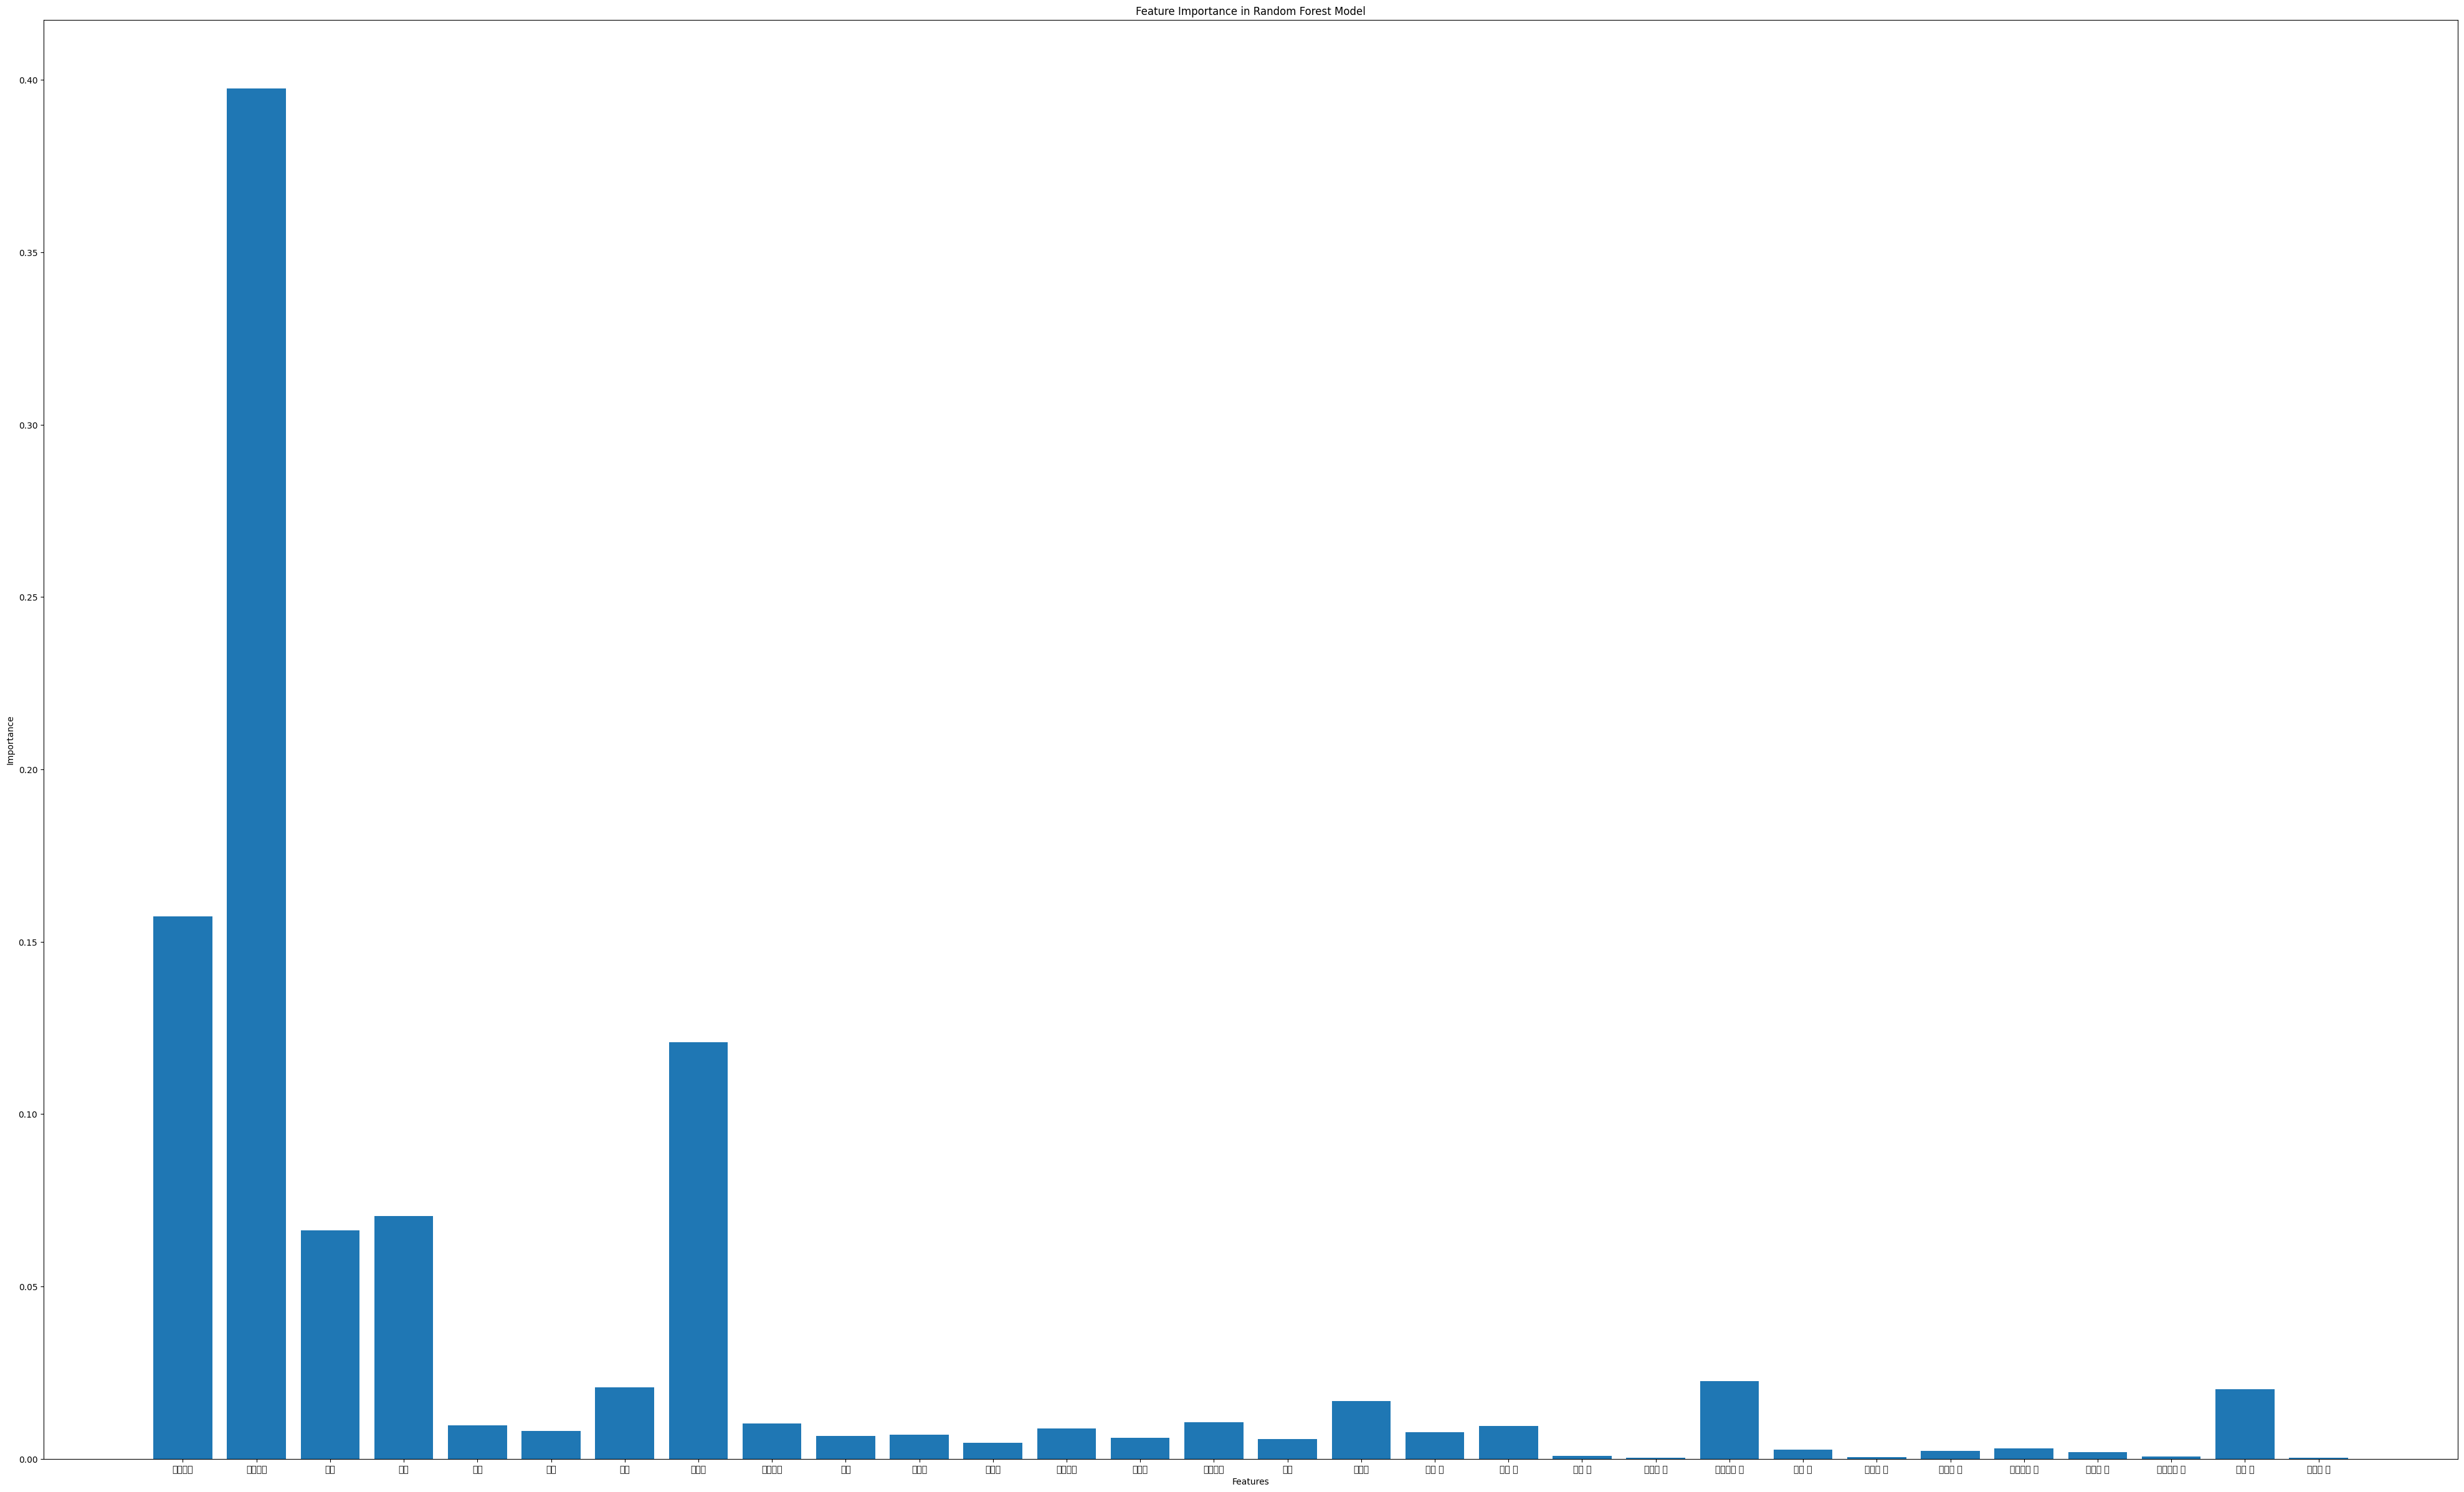

In [ ]:
# 중요도를 시각화할 수도 있습니다.
plt.figure(figsize=(50, 30))
plt.bar(X_train.columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()